In [1]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier

In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sklearn
import sys
from graphviz import Source
from sklearn import tree
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_confusion_matrix
# from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
# from sklearn import decomposition, datasets
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import ParameterGrid
# from sklearn.metrics import mean_squared_error

# Python ≥3.5 is required
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
assert sklearn.__version__ >= "0.20"

# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.style.use('fivethirtyeight')

# to make this notebook's output stable across runs
np.random.seed(42)

IMAGE_PATH = os.path.join('./images')


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


# Loading the data

In [3]:
DATA_PATH = '../MLP2/input/'

# loading the audio file data
audio_df = pd.read_csv(DATA_PATH+'audio_data.csv') # we probably wont use this until we know how to neural network
audio_means_df = pd.read_csv(
    DATA_PATH + 'audio_means.csv')

# loading the .csv file data
song_dropped_df = pd.read_csv(
    DATA_PATH + 'dropped.csv')
song_filled_df = pd.read_csv(
    DATA_PATH + 'mean_filled.csv')

In [4]:
song_dropped_df = song_dropped_df.drop(columns=['artist_name','track_name','instance_id'])
song_filled_df = song_filled_df.drop(columns=['artist_name','track_name'])

In [5]:
keys = dict()
i = 0
for key in sorted(song_filled_df['key'].unique()):
    keys[key] = i
    i+=1

modes = dict({song_filled_df['mode'].unique()[0]:0, song_filled_df['mode'].unique()[1]:1})

In [6]:
song_dropped_df['key'] = song_dropped_df['key'].apply(lambda x: keys[x])
song_dropped_df['mode'] = song_dropped_df['mode'].apply(lambda x: modes[x])

song_filled_df['key'] = song_filled_df['key'].apply(lambda x: keys[x])
song_filled_df['mode'] = song_filled_df['mode'].apply(lambda x: modes[x])

In [7]:
audio_genres = audio_df['genre'].unique()
dropped_genres = song_dropped_df['music_genre'].unique()
filled_genres = song_filled_df['music_genre'].unique()

audio_features = audio_means_df.columns.drop('genre')
dropped_features = song_dropped_df.columns.drop('music_genre')
filled_features = song_filled_df.columns.drop('music_genre')

# Modeling

## Splitting the data

Separating data from labels

In [8]:
# audio data with means
X_audio = audio_means_df.loc[:, audio_means_df.columns != 'genre']
y_audio = audio_means_df['genre']

# song data with dropped null values
X_dropped = song_dropped_df.loc[:, song_dropped_df.columns != 'music_genre']
y_dropped = song_dropped_df['music_genre']

# song data with mean filled null values
X_filled = song_filled_df.loc[:, song_filled_df.columns != 'music_genre']
y_filled = song_filled_df['music_genre']

In [9]:
print(len(X_audio))
print(len(X_dropped))
print(len(X_filled))

1000
40560
50000


creating the splits

In [10]:
# audio data with means
X_audio_train, X_audio_test, y_audio_train, y_audio_test = train_test_split(
    X_audio, y_audio, test_size=0.20)

X_dropped_train, X_dropped_test, y_dropped_train, y_dropped_test = train_test_split(
    X_dropped, y_dropped, test_size=0.30)

X_filled_train, X_filled_test, y_filled_train, y_filled_test = train_test_split(
    X_filled, y_filled, test_size=0.30)


## Training

In [12]:
# def test_splits(pipe, params, X, y, df, model, test_size=[.15,0.2, 0.25, 0.3]):
#     for size in test_size:
#         X_train, X_test, y_train, y_test = train_test_split(X_audio, y_audio, test_size=size)

def run_GSCV(pipe, params, X, y, label):
    clf_GSCV = GridSearchCV(pipe, params)
    clf_GSCV.fit(X, y)
    df = pd.DataFrame(clf_GSCV.cv_results_)
    df['label'] = label
    return df

### Decision Tree

In [15]:
sc = StandardScaler()
dtreeClf = tree.DecisionTreeClassifier()

pipe = Pipeline(steps=[('sc', sc),
                       ('dtreeClf', dtreeClf)])

n_components = list(range(1, X_audio.shape[1] + 1, 1))

criterion = ['gini', 'entropy']
max_depth = [4, 6, 8, 10]

parameters = dict(
                  dtreeClf__criterion=criterion,
                  dtreeClf__max_depth=max_depth)
                  
tree_results_df = pd.DataFrame()
tree_results_df = tree_results_df.append(
    run_GSCV(pipe, parameters, X_audio, y_audio, 'Audio')).append(
    run_GSCV(pipe, parameters, X_dropped, y_dropped, 'Dropped')).append(
    run_GSCV(pipe, parameters, X_filled, y_filled, 'Filled'))

In [16]:
best_audio_tree = tree_results_df[(tree_results_df.rank_test_score == 1) &
                (tree_results_df.label == 'Audio')]

best_dropped_tree = tree_results_df[(tree_results_df.rank_test_score == 1) &
                                  (tree_results_df.label == 'Dropped')]

best_filled_tree = tree_results_df[(tree_results_df.rank_test_score == 1) &
                                    (tree_results_df.label == 'Filled')]

In [17]:

clf_audio = DecisionTreeClassifier(
    criterion=best_audio_tree['param_dtreeClf__criterion'].values[0],
    max_depth=best_audio_tree['param_dtreeClf__max_depth'].values[0]).fit(X_audio_train, y_audio_train)

clf_dropped = DecisionTreeClassifier(
    criterion=best_dropped_tree['param_dtreeClf__criterion'].values[0],
    max_depth=best_dropped_tree['param_dtreeClf__max_depth'].values[0]).fit(X_dropped_train, y_dropped_train)

clf_filled = DecisionTreeClassifier(
    criterion=best_filled_tree['param_dtreeClf__criterion'].values[0],
    max_depth=best_filled_tree['param_dtreeClf__max_depth'].values[0]).fit(X_filled_train, y_filled_train)

y_pred_audio = clf_audio.predict(X_audio_test)
y_pred_dropped = clf_dropped.predict(X_dropped_test)
y_pred_filled = clf_filled.predict(X_filled_test)

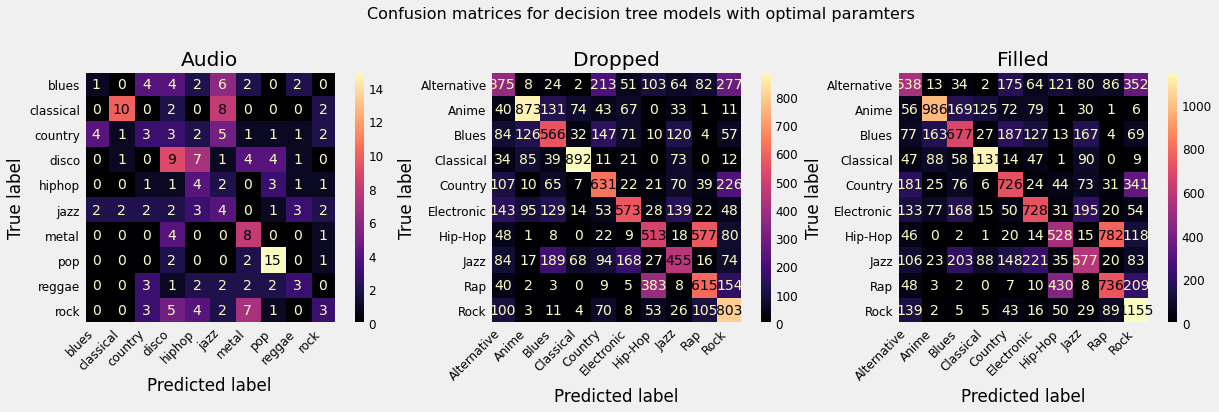

In [97]:
fig, axs = plt.subplots(1,3, figsize = (20,5))

plot_confusion_matrix(clf_audio, X_audio_test, y_audio_test, ax=axs[0], cmap = 'magma')
plot_confusion_matrix(clf_dropped, X_dropped_test, y_dropped_test, ax=axs[1], cmap='magma')
plot_confusion_matrix(clf_filled, X_filled_test, y_filled_test, ax=axs[2], cmap='magma')

axs[0].set(title='Audio')
axs[1].set(title='Dropped')
axs[2].set(title='Filled')

for i in range(3):
    axs[i].set_xticklabels(
        axs[i].get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )
    axs[i].grid(False)
plt.suptitle(
    'Confusion matrices for decision tree models with optimal paramters', fontsize=16)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.8,
                    wspace=0.2,
                    hspace=0.4)
plt.show()

In [19]:
result_metrics_audio = classification_report(y_audio_test, y_pred_audio)
result_metrics_dropped = classification_report(y_dropped_test, y_pred_dropped)
result_metrics_filled = classification_report(y_filled_test, y_pred_filled)

print('\n\nAudio\n', result_metrics_audio)
print('\n\nDropped\n', result_metrics_dropped)
print('\n\nFilled\n',result_metrics_filled)



Audio
               precision    recall  f1-score   support

       blues       0.14      0.05      0.07        21
   classical       0.71      0.45      0.56        22
     country       0.19      0.13      0.15        23
       disco       0.27      0.33      0.30        27
      hiphop       0.17      0.31      0.22        13
        jazz       0.13      0.19      0.16        21
       metal       0.31      0.62      0.41        13
         pop       0.56      0.75      0.64        20
      reggae       0.27      0.20      0.23        15
        rock       0.25      0.12      0.16        25

    accuracy                           0.30       200
   macro avg       0.30      0.31      0.29       200
weighted avg       0.30      0.30      0.29       200



Dropped
               precision    recall  f1-score   support

 Alternative       0.36      0.31      0.33      1199
       Anime       0.72      0.69      0.70      1273
       Blues       0.49      0.47      0.48      1217
   C

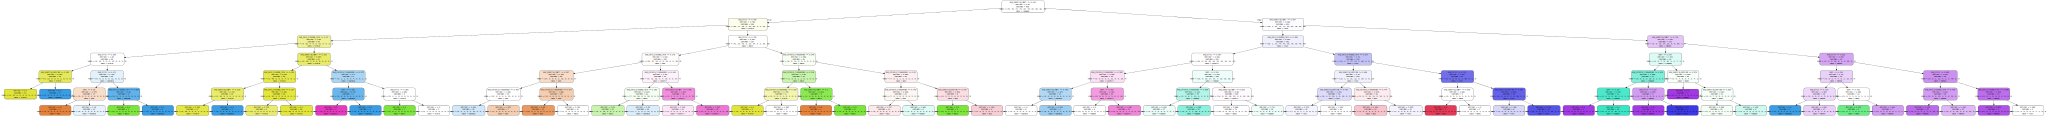

In [20]:
dot_data = export_graphviz(
    clf_audio,
    rounded=True,
    filled=True,
    feature_names=audio_features,
    class_names=audio_genres
)

out_file = os.path.join(IMAGE_PATH, "audio_tree.pdf")

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"65,50!"')
pydot_graph.write_pdf(out_file)
Source(pydot_graph.to_string())


In [21]:
dot_data = export_graphviz(
    clf_dropped,
    rounded=True,
    filled=True,
    feature_names=dropped_features,
    class_names=dropped_features
)

out_file = os.path.join(IMAGE_PATH, "dropped_tree.pdf")

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"100,100!"')
pydot_graph.write_pdf(out_file)
Source(pydot_graph.to_string())


In [22]:
dot_data = export_graphviz(
    clf_filled,
    rounded=True,
    filled=True,
    feature_names=filled_features,
    class_names=filled_features
)
out_file = os.path.join(IMAGE_PATH, "filled_tree.pdf")

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"100,100!"')
pydot_graph.write_pdf(out_file)
Source(pydot_graph.to_string())

### kNN Classifier

In [28]:
sc = StandardScaler()
knn = KNeighborsClassifier()

pipe = Pipeline(steps=[('sc', sc),
                       ('knn', knn)])

n_components = list(range(1, X_audio.shape[1] + 1, 1))

neighbor_counts = [5, 10, 20, 30, 50]

parameters = dict(knn__n_neighbors=neighbor_counts)

knn_results_df = pd.DataFrame()
knn_results_df = knn_results_df.append(
    run_GSCV(pipe, parameters, X_audio, y_audio, 'Audio')).append(
    run_GSCV(pipe, parameters, X_dropped, y_dropped, 'Dropped')).append(
    run_GSCV(pipe, parameters, X_filled, y_filled, 'Filled'))

In [55]:
knn_results_df.reset_index(inplace=True, drop=True)
knn_results_df = knn_results_df.drop(columns='index')

In [44]:
best_audio_knn = knn_results_df[(knn_results_df.rank_test_score == 1) &
                                (knn_results_df.label == 'Audio')]

best_dropped_knn = knn_results_df[(knn_results_df.rank_test_score == 1) &
                                  (knn_results_df.label == 'Dropped')]

best_filled_knn = knn_results_df[(knn_results_df.rank_test_score == 1) &
                                 (knn_results_df.label == 'Filled')]


In [50]:
knn_audio = KNeighborsClassifier(n_neighbors=best_audio_knn['param_knn__n_neighbors'].values[0]).fit(
    X_audio_train, y_audio_train)
knn_dropped = KNeighborsClassifier(
    n_neighbors=best_dropped_knn['param_knn__n_neighbors'].values[0]).fit(X_dropped_train, y_dropped_train)
knn_filled = KNeighborsClassifier(n_neighbors=best_filled_knn['param_knn__n_neighbors'].values[0]).fit(
    X_filled_train, y_filled_train)

y_pred_knn_audio = knn_audio.predict(X_audio_test)
y_pred_knn_dropped = knn_dropped.predict(X_dropped_test)
y_pred_knn_filled = knn_filled.predict(X_filled_test)

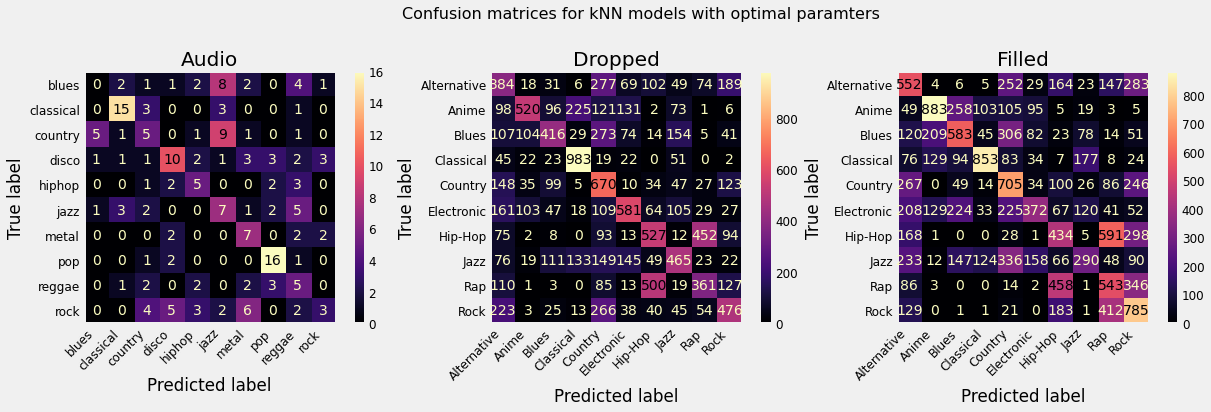

In [99]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

plot_confusion_matrix(knn_audio, X_audio_test,
                      y_audio_test, ax=axs[0], cmap='magma')
plot_confusion_matrix(knn_dropped, X_dropped_test,
                      y_dropped_test, ax=axs[1], cmap='magma')
plot_confusion_matrix(knn_filled, X_filled_test,
                      y_filled_test, ax=axs[2], cmap='magma')

axs[0].set(title='Audio')
axs[1].set(title='Dropped')
axs[2].set(title='Filled')

for i in range(3):
    axs[i].set_xticklabels(
        axs[i].get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )
    axs[i].grid(False)
plt.suptitle(
    'Confusion matrices for kNN models with optimal paramters', fontsize=16)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.8,
                    wspace=0.2,
                    hspace=0.4)
plt.show()


In [53]:
result_metrics_audio = classification_report(y_audio_test, y_pred_knn_audio)
result_metrics_dropped = classification_report(
    y_dropped_test, y_pred_knn_dropped)
result_metrics_filled = classification_report(y_filled_test, y_pred_knn_filled)

print('\n\nAudio\n', result_metrics_audio)
print('\n\nDropped\n', result_metrics_dropped)
print('\n\nFilled\n',result_metrics_filled)



Audio
               precision    recall  f1-score   support

       blues       0.00      0.00      0.00        21
   classical       0.65      0.68      0.67        22
     country       0.25      0.22      0.23        23
       disco       0.45      0.37      0.41        27
      hiphop       0.33      0.38      0.36        13
        jazz       0.23      0.33      0.27        21
       metal       0.32      0.54      0.40        13
         pop       0.62      0.80      0.70        20
      reggae       0.19      0.33      0.24        15
        rock       0.33      0.12      0.18        25

    accuracy                           0.36       200
   macro avg       0.34      0.38      0.35       200
weighted avg       0.35      0.36      0.34       200



Dropped
               precision    recall  f1-score   support

 Alternative       0.27      0.32      0.29      1199
       Anime       0.63      0.41      0.50      1273
       Blues       0.48      0.34      0.40      1217
   C

### Logistic Regression

In [57]:
from sklearn.linear_model import LogisticRegression

In [83]:
sc = StandardScaler()
logreg = LogisticRegression()

pipe = Pipeline(steps=[('sc', sc),
                       ('logreg', logreg)])

solvers = ['lbfgs','liblinear','newton-cg','sag','saga']

max_iters = [100, 1000, 10000, 100000, 1000000]

parameters = dict(logreg__solver=solvers,logreg__max_iter=max_iters)

logreg_results_df = pd.DataFrame()
logreg_results_df = logreg_results_df.append(
    run_GSCV(pipe, parameters, X_audio, y_audio, 'Audio')).append(
    run_GSCV(pipe, parameters, X_dropped, y_dropped, 'Dropped')).append(
    run_GSCV(pipe, parameters, X_filled, y_filled, 'Filled'))

/Users/miarodgers/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/miarodgers/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/miarodgers/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/miarodgers/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/miarodgers/opt/anaconda3/lib/python3.8/site-packages/skle

In [84]:
best_audio_logreg = logreg_results_df[(logreg_results_df.rank_test_score == 1) &
                                      (logreg_results_df.label == 'Audio')]

best_dropped_logreg = logreg_results_df[(logreg_results_df.rank_test_score == 1) &
                                     (logreg_results_df.label == 'Dropped')]

best_filled_logreg = logreg_results_df[(logreg_results_df.rank_test_score == 1) &
                                       (logreg_results_df.label == 'Filled')]

In [74]:
best_filled_logreg


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
2       1.585043      0.148945         0.012891        0.001667   
4       1.801359      0.344553         0.014651        0.002919   
6       1.669287      0.269639         0.012786        0.001231   
8       1.465316      0.090554         0.011830        0.000819   

  param_logreg__max_iter param_logreg__solver  \
2                   1000                lbfgs   
4                  10000                lbfgs   
6                 100000                lbfgs   
8                1000000                lbfgs   

                                              params  split0_test_score  \
2  {'logreg__max_iter': 1000, 'logreg__solver': '...             0.5149   
4  {'logreg__max_iter': 10000, 'logreg__solver': ...             0.5149   
6  {'logreg__max_iter': 100000, 'logreg__solver':...             0.5149   
8  {'logreg__max_iter': 1000000, 'logreg__solver'...             0.5149   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
2             0.5168              0.521              0.514             0.5157   
4             0.5168              0.521              0.514             0.5157   
6             0.5168              0.521              0.514             0.5157   
8             0.5168              0.521              0.514             0.5157   

   mean_test_score  std_test_score  rank_test_score   label  
2          0.51648        0.002441                1  Filled  
4          0.51648        0.002441                1  Filled  
6          0.51648        0.002441                1  Filled  
8          0.51648        0.002441                1  Filled

In [85]:
print('best audio parameters:\n', '--max_iter--\n', best_audio_logreg.param_logreg__max_iter.values,
      '\n--solver--\n', best_audio_logreg.param_logreg__solver.values[0])

print('\n\nbest dropped parameters:\n', '--max_iter--\n', best_dropped_logreg.param_logreg__max_iter.values,
      '\n--solver--\n', best_dropped_logreg.param_logreg__solver.values[0])

print('\n\nbest filled parameters:\n', '--max_iter--\n', best_filled_logreg.param_logreg__max_iter.values,
      '\n--solver--\n', best_filled_logreg.param_logreg__solver.values[0])


best audio parameters:
 --max_iter--
 [100 100 100 100 1000 1000 1000 1000 10000 10000 10000 10000 100000 100000
 100000 100000 1000000 1000000 1000000 1000000] 
--solver--
 lbfgs


best dropped parameters:
 --max_iter--
 [100 1000 1000 10000 10000 100000 100000 1000000 1000000] 
--solver--
 newton-cg


best filled parameters:
 --max_iter--
 [1000 10000 100000 1000000 1000000] 
--solver--
 lbfgs


In [86]:
logreg_audio = LogisticRegression(solver=best_audio_logreg['param_logreg__solver'].values[0], max_iter=best_audio_logreg['param_logreg__max_iter'].values[0]).fit(
    X_audio_train, y_audio_train)
logreg_dropped = LogisticRegression(
    solver=best_dropped_logreg['param_logreg__solver'].values[0], max_iter=best_dropped_logreg['param_logreg__max_iter'].values[0]).fit(X_dropped_train, y_dropped_train)
logreg_filled = LogisticRegression(solver=best_filled_logreg['param_logreg__solver'].values[0], max_iter=best_filled_logreg['param_logreg__max_iter'].values[0]).fit(
    X_filled_train, y_filled_train)

y_pred_logreg_audio = logreg_audio.predict(X_audio_test)
y_pred_logreg_dropped = logreg_dropped.predict(X_dropped_test)
y_pred_logreg_filled = logreg_filled.predict(X_filled_test)

/Users/miarodgers/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


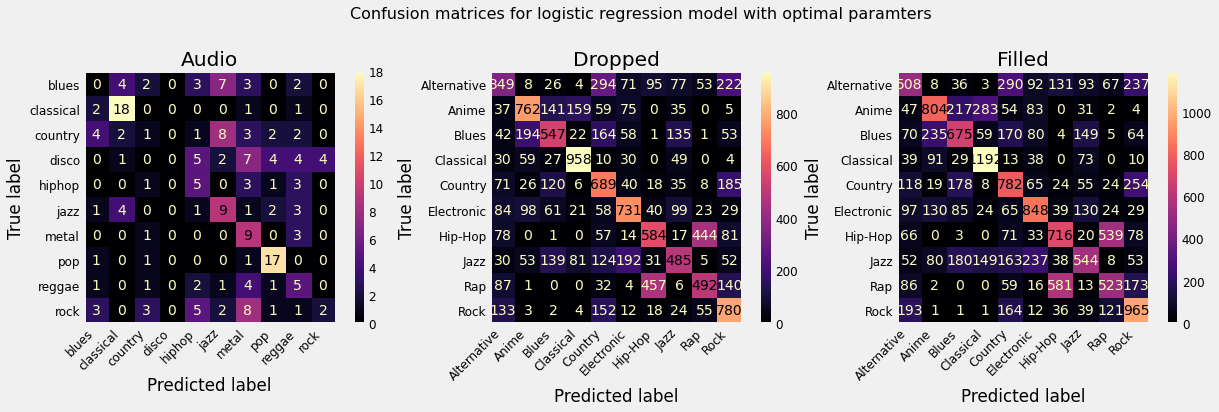

In [94]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

plot_confusion_matrix(logreg_audio, X_audio_test,
                      y_audio_test, ax=axs[0], cmap='magma')
plot_confusion_matrix(logreg_dropped, X_dropped_test,
                      y_dropped_test, ax=axs[1], cmap='magma')
plot_confusion_matrix(logreg_filled, X_filled_test,
                      y_filled_test, ax=axs[2], cmap='magma')

axs[0].set(title='Audio')
axs[1].set(title='Dropped')
axs[2].set(title='Filled')

for i in range(3):
    axs[i].set_xticklabels(
        axs[i].get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )
    axs[i].grid(False)
plt.suptitle('Confusion matrices for logistic regression models with optimal paramters', fontsize = 16)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.8,
                    wspace=0.2,
                    hspace=0.4)
plt.show()

In [92]:
result_metrics_audio = classification_report(y_audio_test, y_pred_logreg_audio)
result_metrics_dropped = classification_report(
    y_dropped_test, y_pred_logreg_dropped)
result_metrics_filled = classification_report(y_filled_test, y_pred_logreg_filled)

print('\n\nAudio\n', result_metrics_audio)
print('\n\nDropped\n', result_metrics_dropped)
print('\n\nFilled\n',result_metrics_filled)

/Users/miarodgers/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




Audio
               precision    recall  f1-score   support

       blues       0.00      0.00      0.00        21
   classical       0.62      0.82      0.71        22
     country       0.10      0.04      0.06        23
       disco       0.00      0.00      0.00        27
      hiphop       0.23      0.38      0.29        13
        jazz       0.31      0.43      0.36        21
       metal       0.23      0.69      0.34        13
         pop       0.61      0.85      0.71        20
      reggae       0.21      0.33      0.26        15
        rock       0.33      0.08      0.13        25

    accuracy                           0.33       200
   macro avg       0.26      0.36      0.28       200
weighted avg       0.26      0.33      0.27       200



Dropped
               precision    recall  f1-score   support

 Alternative       0.37      0.29      0.33      1199
       Anime       0.63      0.60      0.62      1273
       Blues       0.51      0.45      0.48      1217
   C

### Random Forest